<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/05_fine%20tuning%20in%20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tune a Neural Network - a fastai implementation for wild animals classification

The following notebook leverage Chapter 5 from the FastAI book in order to participate in a driven AI challenge where we are asked to classify wild animals with camera shots taken in movement, in nature, and at different times of the day. This is a real problem with real and not perfect data. As we will see, fastai transfer learning, data augmentation and other capabilities allow me to find state of the art performance on that problem and become the current leader of the board.

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Can you classify the wildlife species that appear in camera trap images collected by conservation researchers?

In this challenge, we will take a look at object classification for wildlife species. Classifying wildlife is an important step to sort through images, quantify observations, and quickly find those with individual species. [driven data competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/
)

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. That's where machine learning can help! Advances in computer vision can help automate tasks like species detection and identification, so that humans can spend more time learning from and protecting these ecologies.


# Getting the data right

The first challenge is to consolidate the training and validation data in a format very similar to the oxford pet data set, where every image has first the class followed by an underscored and a number. [pet data set link](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In order to do that, I add the class of each image into the metadata file so it looks like this:

In [6]:
train_features = pd.read_csv("drive/MyDrive/wildlife/train_features/train_features.csv", index_col="id")
#test_features = pd.read_csv("test_features.csv", index_col="id")
#train_labels = pd.read_csv("drive/MyDrive/wildlife/train_features/train_labels.csv", index_col="id")

In [7]:
train_features.head()

filepath   site             label
id                                             
ZJ000000  ZJ000000.jpg  S0120              bird
ZJ000001  ZJ000001.jpg  S0069  monkey_prosimian
ZJ000002  ZJ000002.jpg  S0009              bird
ZJ000003  ZJ000003.jpg  S0008  monkey_prosimian
ZJ000004  ZJ000004.jpg  S0036           leopard

With this structure I can map each file path with its correspondent label.

The first time I run the code I upload the zip folder containing all the images to use for training and validation, you can unzip it using the following command and adapting for your own file and path.

In [ ]:
#!unzip 'gdrive/MyDrive/wildlife/train_features.zip' -d 'gdrive/MyDrive/wildlife/train_features'

I use the file beanchmark.ipynb to get a feeling of the performance of a super fast implementation, for the sake of keeping the length of this notebook short I remove the code but you can see the results in my blogpost [blog post](https://alanfortunysicart.blogspot.com/2022/05/fastai-deep-learning-journey-part-5.html) and pull the notebook from my github [github](https://github.com/afortuny/DeepLearningFastAI/blob/main/benchmark.ipynb). 

# Rename the folders as class_numeric id.jpg

As I explained, the goal now is to rename each images, subtuting the current image id by class_num id.jpg. As you will see I come up with the numeric ids as the ids from the file are alphanumeric, and I was too lazy to change the regex that will pick the label from the image name XD. I will leave commented this chunks and recommend you to create a separate location for the renaming in case something goes wrong.

In [10]:
# This is the path where my images are
collection =  '/content/drive/MyDrive/wildlife/train_features/images'

In [11]:
#load metadat
csv_file_path = '/content/drive/MyDrive/wildlife/train_features/train_features.csv'
data_import= pd.read_csv(csv_file_path)   

The following is an example to illustrate the actual name and the target name:

In [ ]:
#this would print the original name
#os.listdir(collection)[1]

# this will print the target name label_id.jpg
#NOTE it will not work after you have rename all the assets!!!
#(data_import.loc[data_import['filepath'] == os.listdir(collection)[1],'label'] + "_"+ str(1) + '.jpg').to_string()

The following loop iteratos across all the images, find the label and pasted together with a unique numeric identifier i, with the image type jpg.

In [47]:
#i=0
#for images in os.listdir(collection):
  #i=i+1
  #newname = (data_import.loc[data_import['filepath'] == images,'label'] + "_"+ str(i) + '.jpg').to_string()
  #newname
  #os.rename(collection+'/'+images,collection+'/'+newname)

After that step, all the images for both the training and the validation set will be in the images folder, in the format that the following datablock pipeline will be able to read.

## Set up Data Loaders for Wild Life Images

First of all let's set up the path for our images.

In [12]:
Path('/content/drive/MyDrive/wildlife/train_features/train_features')

Path('/content/drive/MyDrive/wildlife/train_features/train_features')

In [14]:
path = Path('/content/drive/MyDrive/wildlife/train_features/images/')
path.ls()


(#10779) [Path('/content/drive/MyDrive/wildlife/train_features/images/   monkey_prosimian_9780.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   monkey_prosimian_9781.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   monkey_prosimian_9782.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   rodent_9783.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   monkey_prosimian_9784.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   antelope_duiker_9785.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   bird_9786.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   rodent_9787.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   leopard_9788.jpg'),Path('/content/drive/MyDrive/wildlife/train_features/images/   leopard_9789.jpg')...]

In [15]:
path

Path('/content/drive/MyDrive/wildlife/train_features/images')

In [17]:
# Let check that the regular expression we will use for our label processer works as expected

fname = (path).ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

# yes it print only the class

['   monkey_prosimian']

This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequence characters are numerical digits and then the JPEG file extension.

Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the `RegexLabeller` class.:

In [18]:
wild = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = wild.dataloaders(path)

One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call *presizing*. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

To work around these challenges, presizing adopts two strategies:

1. Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions. 
2. Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="https://github.com/fastai/fastbook/blob/master/images/att_00060.png?raw=1">

This picture shows the two steps:

1. *Crop full width or height*: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
2. *Random crop and augment*: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

This way of managing images is key to understand why fastai performs so well, as there is little information loss during the process, and it is quite efficient computationally.


The fastai library also provides simple ways to check your data looks right before training a model, which is an extremely important step. We'll look at those next.

### Checking and Debugging a DataBlock

We will use the `show_batch` metho to confirm our data block is correct:

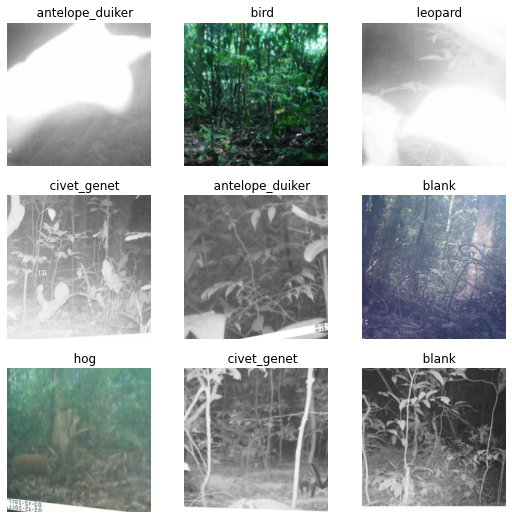

In [20]:
dls.show_batch(nrows=3, ncols=3)

This data set is very hard but in my samples it seems that when the label is set to blanl I could not see any animal and I was able to identify the hog and leopart when displayed. Nothing seems to went wrong, to be extra sure, we can leverage the summary method over the data block.


In [ ]:
#check data block log
wild.summary(path)

# Training the first model

Now we will start by training the first mode and look at the validation loss. Keep in mind that the baseline model gave a validation loss of - 1.82 in the test set and 1.3 in the validation set. Let's see what we get applying transfer learning on a resnet 34 architecture:

In [22]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

I am going deeper into the theory in the blogpost, but here is important to briefly mention what the vision learner and fine tune call does and its parameters:



*   **Vision Learner** : picks our data loader object, a pretrained resnet34 architecture and our desired metric (the kpi that we care)
*   **fine tune** : based on our learner object performs two step approach. First it trains the last layer (head) wit the random weights keeping the other weights constant. In the second step, unfreeze all the weights and train them for the number of epochs requested.



We can already see the following: 

*   The validation loss is after two epochs already better than the baseline with 5 epochs
*   We got 70% accuracy (1-error rate) on the classification of 8 classes.
*   It took in total 15min to run on ~10k images. comparing to 25 min with pytorch on 5% of the data (20 times less) and with higher validation entropy loss ~1.2 and worse accuracy 43%.









FastAI picked the crossentropy loss in that case for us, as we do not specify which one, but it is a very common for multiclass classification problems like the one we are working now. I explain in detail the crossentropy loss in my blog [blog](https://alanfortunysicart.blogspot.com/2022/05/fastai-deep-learning-journey-part-5.html). In this notebook the focus is to understand fine tunning and the E2E delivery of a real competition.

## Model Interpretation

It's very hard to interpret loss functions directly, because they are designed to be things computers can differentiate and optimize, not things that people can understand. That's why we have metrics. These are not used in the optimization process, but just to help us poor humans understand what's going on. In this case, our accuracy is looking pretty good already! So where are we making mistakes?

We can use a confusion matrix to see where our model is doing well, and where it's doing badly:

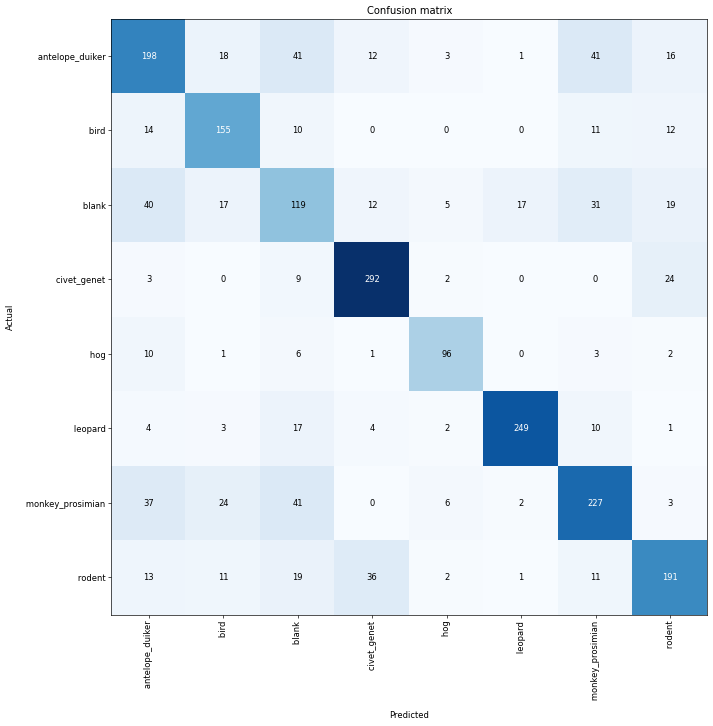

In [26]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Despite we have a quite big matrix, we can see that the diagonal is pretty strong, and some errors are expected (such as the model to struggle to confirm the picture is blank, or differentiate someimes between rodents and civet genet. It is surprising though the errors on monkey with respect antelopes or birds.


To have a quantitative list with the most errors we can look that the most confused method:


In [27]:
interp.most_confused(min_val=5)

[('   antelope_duiker', '   blank', 41),
 ('   antelope_duiker', '   monkey_prosimian', 41),
 ('   monkey_prosimian', '   blank', 41),
 ('   blank', '   antelope_duiker', 40),
 ('   monkey_prosimian', '   antelope_duiker', 37),
 ('   rodent', '   civet_genet', 36),
 ('   blank', '   monkey_prosimian', 31),
 ('   civet_genet', '   rodent', 24),
 ('   monkey_prosimian', '   bird', 24),
 ('   blank', '   rodent', 19),
 ('   rodent', '   blank', 19),
 ('   antelope_duiker', '   bird', 18),
 ('   blank', '   bird', 17),
 ('   blank', '   leopard', 17),
 ('   leopard', '   blank', 17),
 ('   antelope_duiker', '   rodent', 16),
 ('   bird', '   antelope_duiker', 14),
 ('   rodent', '   antelope_duiker', 13),
 ('   antelope_duiker', '   civet_genet', 12),
 ('   bird', '   rodent', 12),
 ('   blank', '   civet_genet', 12),
 ('   bird', '   monkey_prosimian', 11),
 ('   rodent', '   bird', 11),
 ('   rodent', '   monkey_prosimian', 11),
 ('   bird', '   blank', 10),
 ('   hog', '   antelope_duik

Given the quality of the images is hard, to tell, but it seems possible to improve some of the errors such as the differentiation between antelope and monkeys. Instead of fixing the labels, as we did in the brand classifier case to improve model performance [brand classifier](https://alanfortunysicart.blogspot.com/2022/04/fastai-deep-learning-journey-part-2.html), in this notebook we focus on pure model fine tune. 

## Improving Our Model

The first thing we need to set when training a model is the learning rate. It needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

### The Learning Rate Finder

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the *learning rate finder*. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing 

The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):

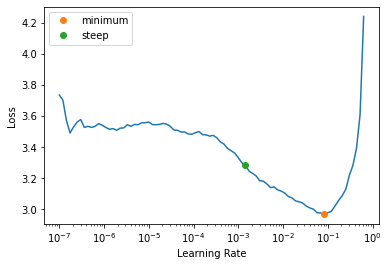

In [28]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [29]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 1.45e-03


We can see on this plot that in the range 1e-6 to 1e-4, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

In [30]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

Now that we have a good learning rate to train our model, let's look at how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning

We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. As we saw in the images from the [Zeiler and Fergus paper](https://arxiv.org/pdf/1311.2901.pdf) the first few layers encode very general concepts, such as finding gradients and edges, and later layers encode concepts that are still very useful for us, such as finding eyeballs and fur.

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task, and only adjust them as required for the specifics of our particular task.

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called *freezing* those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us.

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The `fine_tune` method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior. 
So let's try doing this manually ourselves. First of all we will train the randomly added layers for three epochs, using `fit_one_cycle`. what `fit_one_cycle` does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.

In [31]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

Then we'll unfreeze the model:

In [32]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=9.999999747378752e-06)

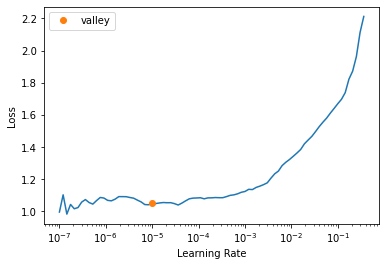

In [33]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [34]:
learn.fit_one_cycle(6, lr_max=1e-5)

This has improved our model a bit (from 0.85 to 0.79 validation loss), but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds:

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="https://github.com/fastai/fastbook/blob/master/images/att_00039.png?raw=1">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [35]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

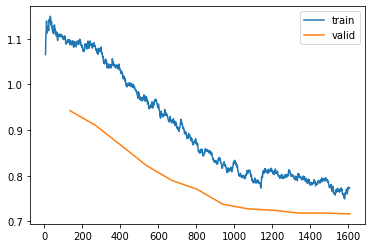

In [36]:
learn.recorder.plot_loss()

As you can see, the training and validation loss keeps getting better and better. As there is already some plateau in the improvement, it does not seem to be very beneficial to go with more epochs (the last epochs improved validation loss less than 1% and error rate stagnate).

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

### Deeper Architectures

In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.) For most of the architectures that we will be seeing in this book, you can create larger versions of them by simply adding more layers. However, since we want to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us.

This is why, in practice, architectures tend to come in a small number of variants. For instance, the ResNet architecture that we are using in this chapter comes in variants with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet. A larger (more layers and parameters; sometimes described as the "capacity" of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:

In [37]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(10, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

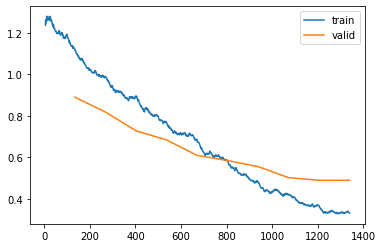

In [38]:
learn.recorder.plot_loss()

Training with Resnet50 gives the best results although we see some slight overfitting as training keeps going down and validation set not so fast. 

In [39]:
learn.export(os.path.abspath('./my_export.pkl'))

You'll see here we've gone back to using `fine_tune`, since it's so handy! We can pass `freeze_epochs` to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

## Conclusion

In this notebook we show how fastai not only works very well on curated almost textbook like data sets, but it is actually providing state of the art results in a few minutes and with very little code. 

In order to explain its success once have to understand its components:


*   **Transfer learning** fastai does not train from scratch, but rather learn from pretrained models on Imagenet
*   **Data Augmentations** fastai performs presizing to ensure almost no information loss or biased is imposed on images during normalization
*   **Learning Rate Finder** fastai allows to easily find the optimal learning rate after running several learning rates on bacthes
*   **Discriminative Learning rate** fastai uses low learning rate for early layers and increases progressively to finalize decreasing it again. This allows for domain specific adaptation with little risk of "bad co adaption"

There are also implementation details that make fastai faster that our "similar" attempt directly from pytorch. We do not deep dive into the details, but applying certain augmentations at batch make the code much faster and avoid rebundant transformations. That would take some time to figure out on our own.




## The time of truth, let's submit our prediction on the test set for the competition

In [ ]:
!unzip '/content/drive/MyDrive/wildlife/test_features.zip' -d 'drive/MyDrive/wildlife'

In [44]:
learn_inf = load_learner('my_export.pkl')

In [71]:
x1 = learn_inf.predict('/content/drive/MyDrive/wildlife/test_features/ZJ016488.jpg')[2]

In [69]:
x2 = learn_inf.predict('/content/drive/MyDrive/wildlife/test_features/ZJ016489.jpg')[2]

In [89]:
txt = 'ZJ016488.jpg'
txt2 = 'ZJ016489.jpg'
txt.split('.jpg')[0]

'ZJ016488'

In [90]:
df = pd.concat([pd.DataFrame(x1),pd.DataFrame(x2)],axis=1)

In [92]:
#id = pd.Series()
id1 = pd.Series(txt.split('.jpg')[0])
id = id.append(id1)
id

0    ZJ016489
0    ZJ016489
0    ZJ016489
0    ZJ016488
dtype: object

In [86]:
id

0    ZJ016489
dtype: object

In [95]:
# This is the path where my images are
test_path =  '/content/drive/MyDrive/wildlife/test_features'

pred = pd.DataFrame()
id = pd.Series()
# the following loop predict prob of each class of the test set and concatenate as pandas the predictions 
# and the photo id as a series
for images in os.listdir(test_path):
  pred1 = learn_inf.predict('/content/drive/MyDrive/wildlife/test_features/' +  images)[2]
  id1 = pd.Series(images.split('.jpg')[0])
  pred = pd.concat([pd.DataFrame(pred),pd.DataFrame(pred1)],axis=1)
  id = id.append(id1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [97]:
classes = learn_inf.dls.vocab

In [129]:
result = pred.transpose()
  
# add id column
result.insert(0, 'id', id)

In [130]:
result.columns = ['id', 'antelope','bird','blank','civet_genet','hog','leopard','monkey_prosimian','rodent']

In [131]:
submission_format = pd.read_csv("/content/drive/MyDrive/wildlife/submission_format.csv", index_col="id")

result.to_csv('predictions.csv')

In [134]:
result.dtypes

id                   object
antelope            float32
bird                float32
blank               float32
civet_genet         float32
hog                 float32
leopard             float32
monkey_prosimian    float32
rodent              float32
dtype: object

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.